In [1]:
%pip install mat73

import mat73
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from numpy import load
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.inspection import permutation_importance
from sklearn.model_selection import KFold, cross_val_score

In [2]:
from google.colab import drive
drive.mount('/content/drive')

# mounted on MyDrive
!ls '/content/drive/'

!cp -r /content/drive/MyDrive/Kato2015_whole_brain_imaging_data /content/Kato2015_whole_brain_imaging_data

Mounted at /content/drive
MyDrive


In [3]:
root_dir = './'
local_path = "/content/Kato2015_whole_brain_imaging_data/"


WT_NoStim_path = local_path + 'WT_NoStim.mat'

wt_nostim_dict = mat73.loadmat(WT_NoStim_path)
wt_nostim = wt_nostim_dict.get('WT_NoStim')
print(f"WT_NoStim dict keys: {wt_nostim.keys()}")

WT_NoStim dict keys: dict_keys(['NeuronNames', 'Opts', 'States', 'dataset', 'deltaFOverF', 'deltaFOverF_bc', 'derivs', 'fps', 'stateParams', 'tv'])


In [4]:
def process_wt_nostim():
    index = 0
    neuron_ids = []
    identified_neuron_ids = []
    states = []
    neuron_trace_data = []

    for x, y in wt_nostim.items():
        if x == 'NeuronNames':
            max = 0
            for idx, v in enumerate(y):
                if len(v) > max:
                    max = len(v)
                    index = idx
                    neuron_ids = v
            identified_neuron_ids = [k for k in neuron_ids if not k.isnumeric()]
            print(f"Using C. elegans GCaMP data with the highest number of neurons monitored, "
                  f"detected neurons len: {len(neuron_ids)}, identified neurons len: {len(identified_neuron_ids)}, IDs: {identified_neuron_ids}")

        if x == 'States':
            states_dict = y[index]
            print(f"state types: {states_dict.keys()}")
            state_dt = states_dict.get("dt")
            state_fwd = states_dict.get("fwd")
            state_nostate = states_dict.get("nostate")
            state_rev1 = states_dict.get("rev1")
            state_rev2 = states_dict.get("rev2")
            state_revsus = states_dict.get("revsus")
            state_slow = states_dict.get("slow")
            state_vt = states_dict.get("vt")

            for idx, v in enumerate(state_dt):
                if v == 1:
                    states.append("dt")
                elif state_fwd[idx] == 1:
                    states.append("fwd")
                elif state_nostate[idx] == 1:
                    states.append("nostate")
                elif state_rev1[idx] == 1:
                    states.append("rev1")
                elif state_rev2[idx] == 1:
                    states.append("rev2")
                elif state_revsus[idx] == 1:
                    states.append("revsus")
                elif state_slow[idx] == 1:
                    states.append("slow")
                elif state_vt[idx] == 1:
                    states.append("vt")
                else:
                    states.append("none")

        if x == 'deltaFOverF_bc':
            neuron_trace_data = y[index]

    return states, neuron_trace_data, neuron_ids, identified_neuron_ids

In [5]:
wt_nostim_behaviours, wt_nostim_neuron_trace_data, wt_nostim_neuron_ids, wt_nostim_identified_neuron_ids = process_wt_nostim()

wt_nostim_behaviour_df = pd.DataFrame({'behaviour': wt_nostim_behaviours})
print(f"\n wt_nostim behaviours data:")
print(wt_nostim_behaviour_df.info())
print(wt_nostim_behaviour_df)

wt_nostim_neuron_trace_df = pd.DataFrame(wt_nostim_neuron_trace_data, columns=wt_nostim_neuron_ids)
wt_nostim_neuron_trace_df = wt_nostim_neuron_trace_df[wt_nostim_identified_neuron_ids]
print(f"\n wt_nostim neuron trace data:")
print(wt_nostim_neuron_trace_df.info())
print(wt_nostim_neuron_trace_df)

Using C. elegans GCaMP data with the highest number of neurons monitored, detected neurons len: 135, identified neurons len: 44, IDs: ['OLQVL', 'OLQDL', 'OLQVR', 'OLQDR', 'RMED', 'RMER', 'RMEL', 'RID', 'SMDVR', 'SMDVL', 'ALA', 'AVAR', 'AVAL', 'ASKR', 'RMEV', 'AVER', 'AVEL', 'SIBDR', 'ASKL', 'AIBR', 'AVBR', 'RIVR', 'RIBR', 'AVBL', 'AIBL', 'RIVL', 'RIBL', 'RIMR', 'SIBVL', 'RIML', 'SMDDR', 'SMDDL', 'RIS', 'VB02', 'AVFR', 'AVFL', 'VB01', 'RIFR', 'DB02', 'SABD', 'VA01', 'RIGL', 'DB01', 'VB03']
state types: dict_keys(['dt', 'fwd', 'nostate', 'rev1', 'rev2', 'revsus', 'slow', 'vt'])

 wt_nostim behaviours data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3134 entries, 0 to 3133
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   behaviour  3134 non-null   object
dtypes: object(1)
memory usage: 24.6+ KB
None
     behaviour
0         slow
1         slow
2       revsus
3       revsus
4       revsus
...        ...
3129      slow

In [6]:
def pre_process_data(df):
    # Create the pipeline
    num_pipeline = Pipeline(steps=[
        ('scaler', StandardScaler())])

    # Fit the pipeline to the training data
    data_prepared = num_pipeline.fit_transform(df)

    return data_prepared

In [7]:
wt_nostim_neuron_trace_train, wt_nostim_neuron_trace_test, wt_nostim_behaviour_train, wt_nostim_behaviour_test = train_test_split(
    wt_nostim_neuron_trace_df,
    wt_nostim_behaviour_df,
    test_size=0.3,
    random_state=42
)

wt_nostim_neuron_trace_train_prepared = pre_process_data(wt_nostim_neuron_trace_train)
print(f"wt_nostim neuron trace train prepared data:")
print(wt_nostim_neuron_trace_train_prepared.shape)
print(wt_nostim_neuron_trace_train_prepared)

wt_nostim_neuron_trace_test_prepared = pre_process_data(wt_nostim_neuron_trace_test)
print(f"\n wt_nostim neuron trace test prepared data:")
print(wt_nostim_neuron_trace_test_prepared.shape)
print(wt_nostim_neuron_trace_test_prepared)

wt_nostim neuron trace train prepared data:
(2193, 44)
[[-1.49282721 -1.12643376 -1.15784883 ... -0.85897533  2.22156575
   0.95757306]
 [ 2.81752427  0.60462851  0.74960544 ... -0.47967343 -0.86812745
  -0.94415558]
 [ 0.16493398  0.15496616  0.07622993 ... -0.07706659 -0.45836846
  -0.69520364]
 ...
 [-0.10398991 -0.4988318   0.31814841 ...  0.60420023 -0.46482259
  -1.12519736]
 [-0.68626653  0.05068121 -0.03989232 ... -1.22636679 -0.33163349
  -0.41066256]
 [-0.77321049 -0.75949046 -0.64052297 ...  1.01764367  0.84519936
   1.46004076]]

 wt_nostim neuron trace test prepared data:
(941, 44)
[[ 1.71340541  3.09191188  1.4107568  ...  0.2279356  -0.42819553
   0.52886064]
 [ 2.57468284 -0.20767196 -0.67810463 ...  0.33049154 -0.80116687
  -1.31137883]
 [-0.91016499 -1.02395551 -0.61333565 ...  0.30714509 -0.34368601
  -1.22571527]
 ...
 [-0.87432657 -1.26989737 -1.50223833 ... -0.59065715 -0.40015945
  -1.29401633]
 [-0.83459631 -0.51495013 -0.38759972 ...  0.98157847 -0.64254314
  -

In [8]:
def confusion_matrix_figure(confusion_matrix, class_names, title):
  fig, ax = plt.subplots(figsize=(18, 9))
  sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", ax=ax, xticklabels=class_names, yticklabels=class_names)
  ax.set_xlabel('Predicted labels')
  ax.set_ylabel('True labels')
  ax.set_title(title)
  plt.show()

In [9]:
# Define logistic regression classifiers
def train_and_evaluate_logistic_regression_classifiers(data_features_train_prepared, data_train_targets, data_features_test_prepared, data_test_targets):
    # Set up hyperparameter grid for tuning
    param_grid = {
      'C': [0.01, 0.1, 1, 10, 100],
      'penalty': ['l2'],
      'solver': ['newton-cg']
    }

    # Initialize classifier
    log_reg = LogisticRegression(max_iter=1000, random_state=42)

    # Initialize GridSearchCV
    grid_search = GridSearchCV(log_reg, param_grid, cv=StratifiedKFold(n_splits=10), scoring='accuracy', verbose=1, n_jobs=-1)

    # Fit model
    grid_search.fit(data_features_train_prepared, data_train_targets.values.ravel())

    # Find the best model
    print(f"LogisticRegression classifier optimal parameters: {grid_search.best_params_}")
    best_clf = grid_search.best_estimator_

    # Predictions on the test set
    clf_preds = best_clf.predict(data_features_test_prepared)

    # Results
    accuracy = accuracy_score(data_test_targets, clf_preds)
    print(f"Logistic Regression Classifier Accuracy: {accuracy * 100: .1f}%\n")

    print(f"Logistic Regression Classifier Confusion Matrix:")
    class_names = data_test_targets['behaviour'].unique()
    confusion_matrix_figure(confusion_matrix(data_test_targets, clf_preds), class_names, "Confusion Matrix - Test Set")

    print("\n Logistic Regression Classifier Classification Report:")
    print(classification_report(data_test_targets, clf_preds))

    return best_clf


Fitting 10 folds for each of 5 candidates, totalling 50 fits
LogisticRegression classifier optimal parameters: {'C': 1, 'penalty': 'l2', 'solver': 'newton-cg'}
Logistic Regression Classifier Accuracy:  89.1%

Logistic Regression Classifier Confusion Matrix:


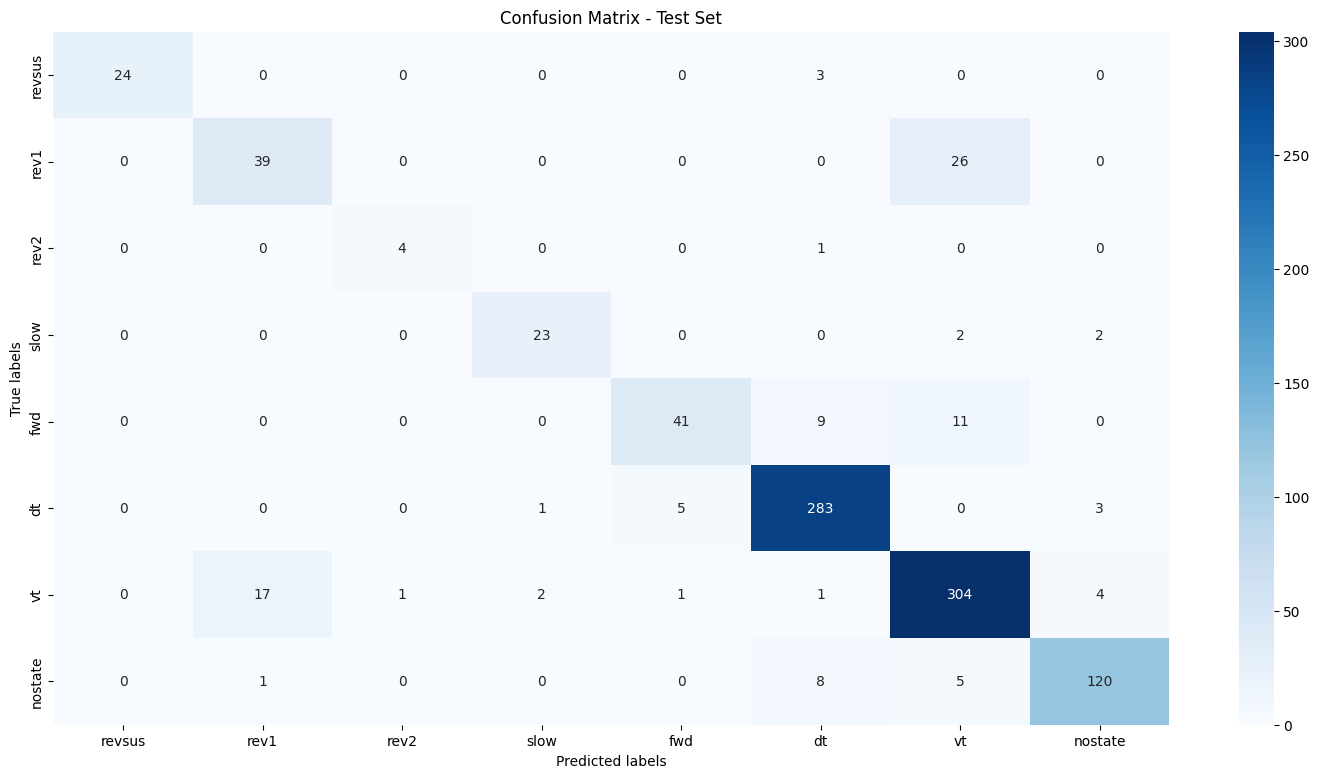


 Logistic Regression Classifier Classification Report:
              precision    recall  f1-score   support

          dt       1.00      0.89      0.94        27
         fwd       0.68      0.60      0.64        65
     nostate       0.80      0.80      0.80         5
        rev1       0.88      0.85      0.87        27
        rev2       0.87      0.67      0.76        61
      revsus       0.93      0.97      0.95       292
        slow       0.87      0.92      0.90       330
          vt       0.93      0.90      0.91       134

    accuracy                           0.89       941
   macro avg       0.87      0.82      0.85       941
weighted avg       0.89      0.89      0.89       941



In [10]:
wt_nostim_lr_clf = train_and_evaluate_logistic_regression_classifiers(
    wt_nostim_neuron_trace_train_prepared,
    wt_nostim_behaviour_train,
    wt_nostim_neuron_trace_test_prepared,
    wt_nostim_behaviour_test
)

In [11]:
# define random forest classifier
from sklearn.ensemble import RandomForestClassifier

def train_and_evaluate_random_forest_classifiers(data_features_train_prepared, data_train_targets,
                                                 data_features_test_prepared, data_test_targets):
    # Set up a hyperparameter grid search using GridSearchCV
    param_grid = {
        'n_estimators': [50, 100, 150],
        'max_depth': [10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    rf = RandomForestClassifier(random_state=42)
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                               cv=5, n_jobs=-1, verbose=2, scoring='accuracy')

    # Fit the model to the training data
    grid_search.fit(data_features_train_prepared, data_train_targets.values.ravel())

    # Use the best estimator from the grid search to predict the classes of the test set
    best_clf = grid_search.best_estimator_
    print(f"Random Forest classifier optimal parameters: {grid_search.best_params_}")
    clf_preds = best_clf.predict(data_features_test_prepared)

    # Calculate the accuracy of the model
    accuracy = accuracy_score(data_test_targets, clf_preds)
    print(f"Random Forest Classifier Accuracy: {accuracy * 100: .1f}%\n")

    # Calculate the confusion matrix
    print(f"Random Forest Classifier Confusion Matrix:")
    class_names = data_test_targets['behaviour'].unique()
    confusion_matrix_figure(confusion_matrix(data_test_targets, clf_preds), class_names, "Confusion Matrix - Test Set")

    # Print the classification report
    print("\n Random Forest Classifier Classification Report:")
    print(classification_report(data_test_targets, clf_preds))

    return best_clf

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Random Forest classifier optimal parameters: {'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}
Random Forest Classifier Accuracy:  93.3%

Random Forest Classifier Confusion Matrix:


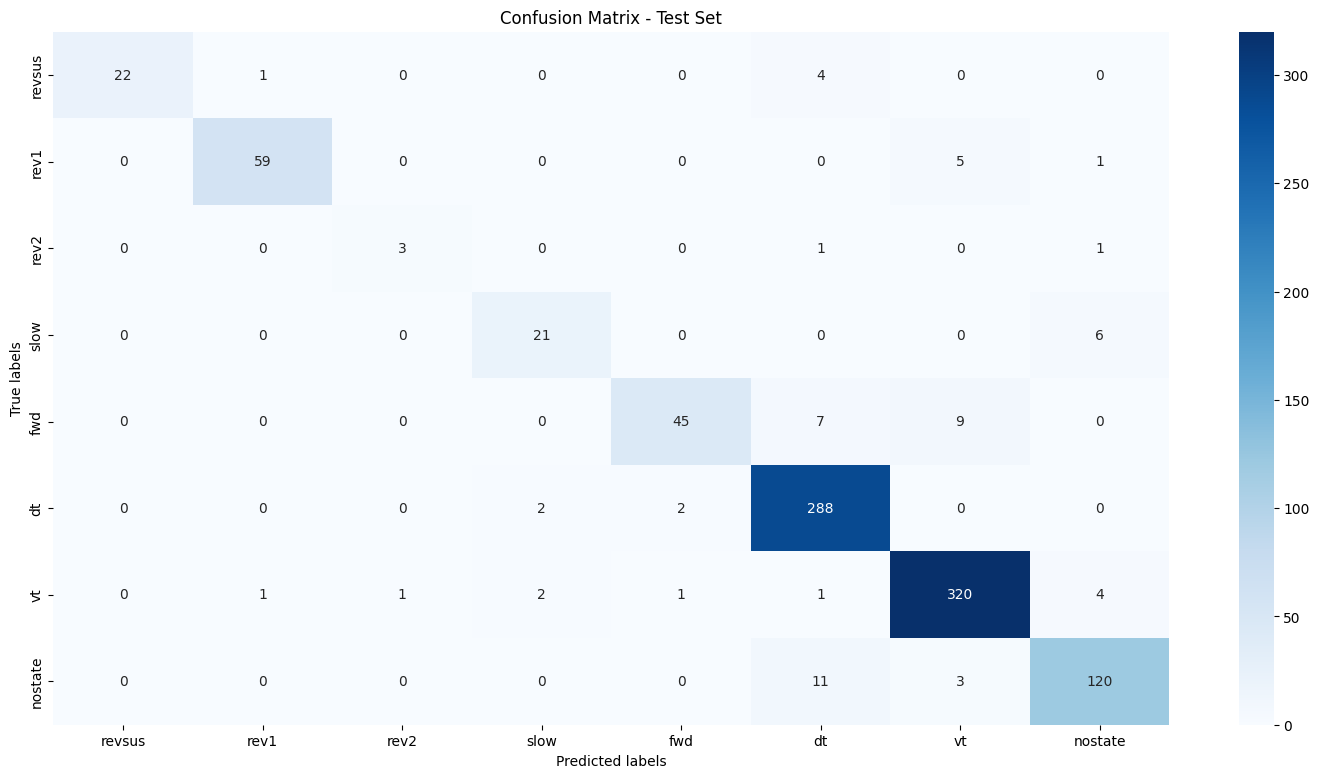


 Random Forest Classifier Classification Report:
              precision    recall  f1-score   support

          dt       1.00      0.81      0.90        27
         fwd       0.97      0.91      0.94        65
     nostate       0.75      0.60      0.67         5
        rev1       0.84      0.78      0.81        27
        rev2       0.94      0.74      0.83        61
      revsus       0.92      0.99      0.95       292
        slow       0.95      0.97      0.96       330
          vt       0.91      0.90      0.90       134

    accuracy                           0.93       941
   macro avg       0.91      0.84      0.87       941
weighted avg       0.93      0.93      0.93       941



In [12]:
wt_nostim_rf_clf = train_and_evaluate_random_forest_classifiers(
    wt_nostim_neuron_trace_train_prepared,
    wt_nostim_behaviour_train,
    wt_nostim_neuron_trace_test_prepared,
    wt_nostim_behaviour_test
)

In [13]:
def find_relevant_features_from_rf_clf_all_behaviours(model, X):
    feature_importances = model.feature_importances_
    feature_importance = pd.DataFrame({'Neuron': X.columns,
                                       'Importance': feature_importances})
    feature_importance = feature_importance.sort_values('Importance', ascending=False).head(30)
    feature_importance_copy = feature_importance.sort_values('Importance', ascending=True)

    ax = feature_importance_copy.plot(x='Neuron', y='Importance', kind='barh', figsize=(1280/96, 720/96))
    ax.set_title('Neuronal importance of all behaviours')

    return feature_importance

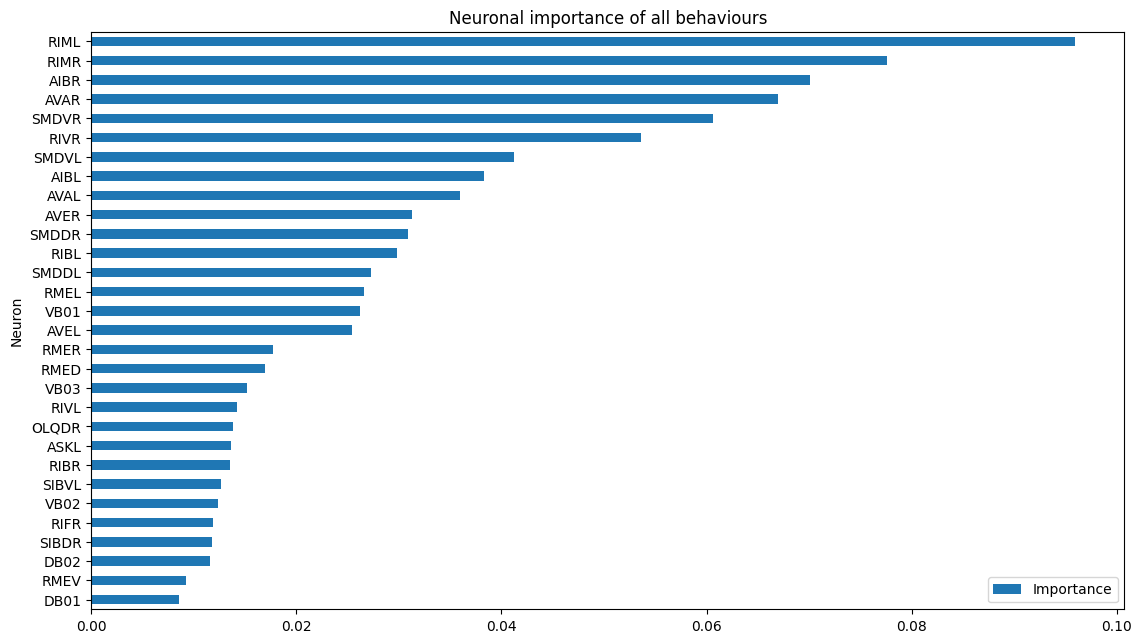

In [14]:
wt_nostim_behaviours_feature_importance_df = find_relevant_features_from_rf_clf_all_behaviours(
    wt_nostim_rf_clf,
    wt_nostim_neuron_trace_df
)

In [15]:
def figure_wt_nostim_neuron_trace(df, feature_importance_df):
    neurons = feature_importance_df['Neuron'].head(15).tolist()
    neuron_dict = {}
    for k in neurons:
        neuron_dict[k] = df[k].tolist()
    filtered_df = pd.DataFrame(neuron_dict)

    col = len(filtered_df.columns)

    fig, axes = plt.subplots(nrows=col, ncols=1, sharex=True, figsize=(15, 15))
    fig.suptitle('Neuronal traces of permutation importance')

    for c, ax in zip(filtered_df, axes):
        filtered_df[c].plot(ax=ax, label=f'{c}')
        ax.legend(loc='upper right')

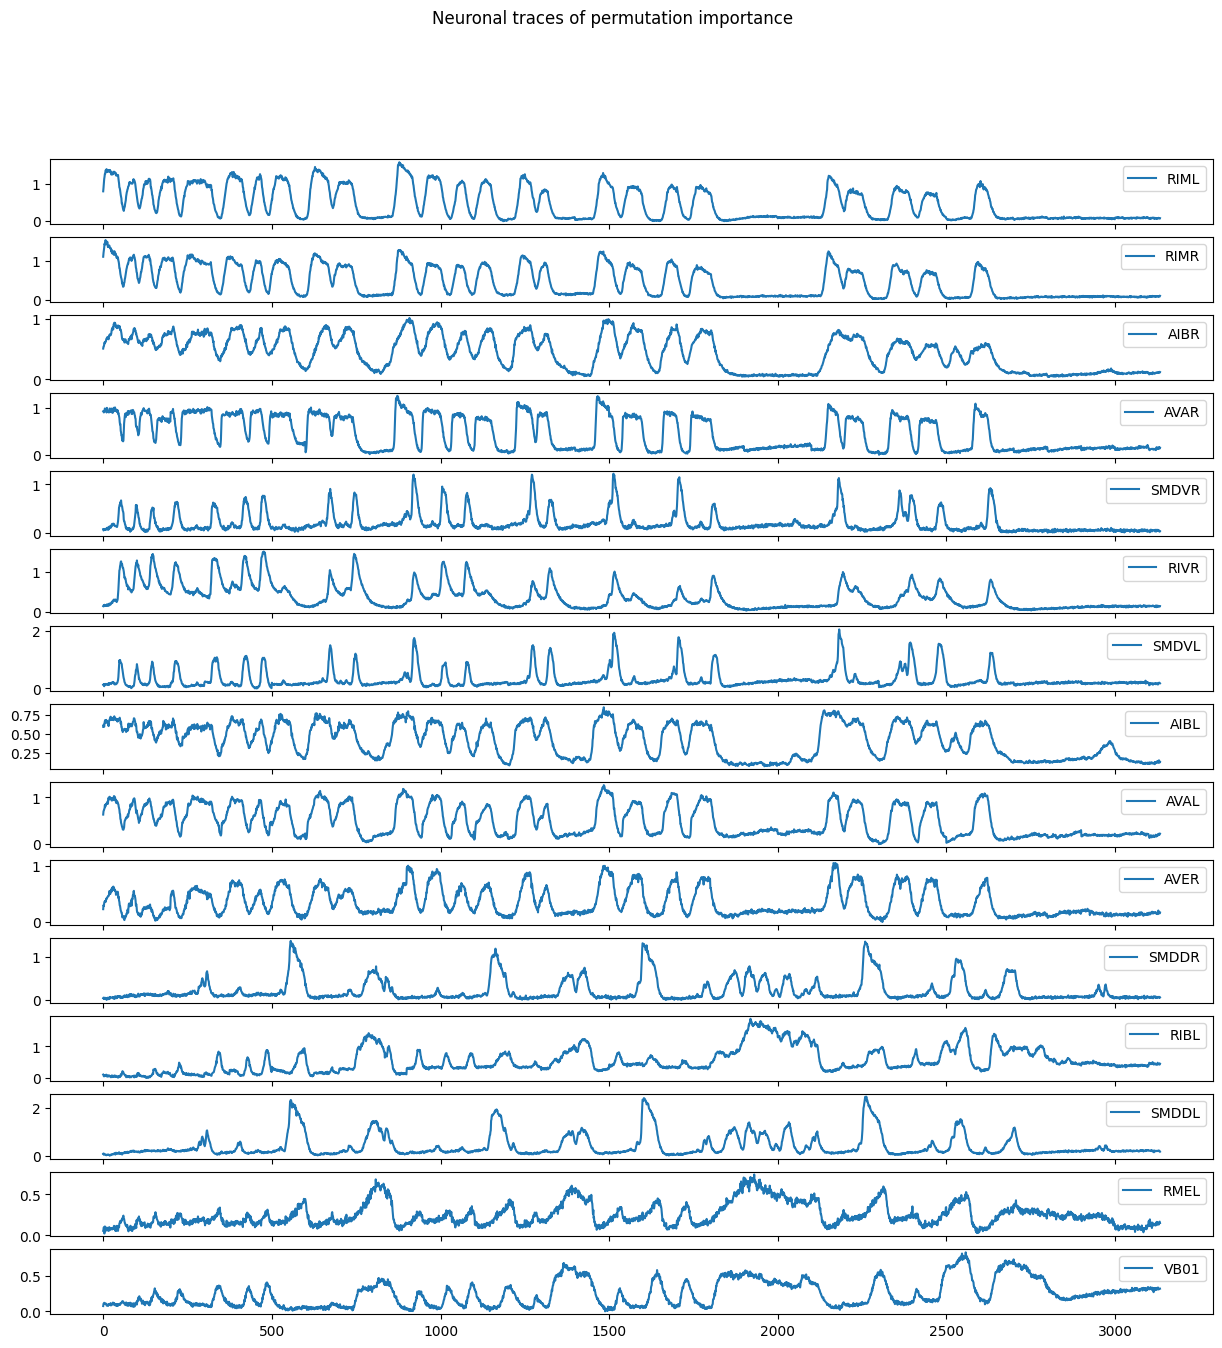

In [16]:
figure_wt_nostim_neuron_trace(
    wt_nostim_neuron_trace_df,
    wt_nostim_behaviours_feature_importance_df
)

In [17]:
def find_relevant_features_from_lr_clf_one_behaviour(model, X, behaviour):
    classes = model.classes_

    index = list(classes).index(behaviour)

    coefficients = model.coef_[index]

    feature_importance = pd.DataFrame({'Neuron': X.columns, 'Importance': np.abs(coefficients)})
    feature_importance = feature_importance.sort_values('Importance', ascending=False).head(30)

    feature_importance_copy = feature_importance.sort_values('Importance', ascending=True)

    ax = feature_importance_copy.plot(x='Neuron', y='Importance', kind='barh', figsize=(1280/96, 720/96))
    ax.set_title(f'Neuronal importance of {behaviour} behaviour')

    return feature_importance

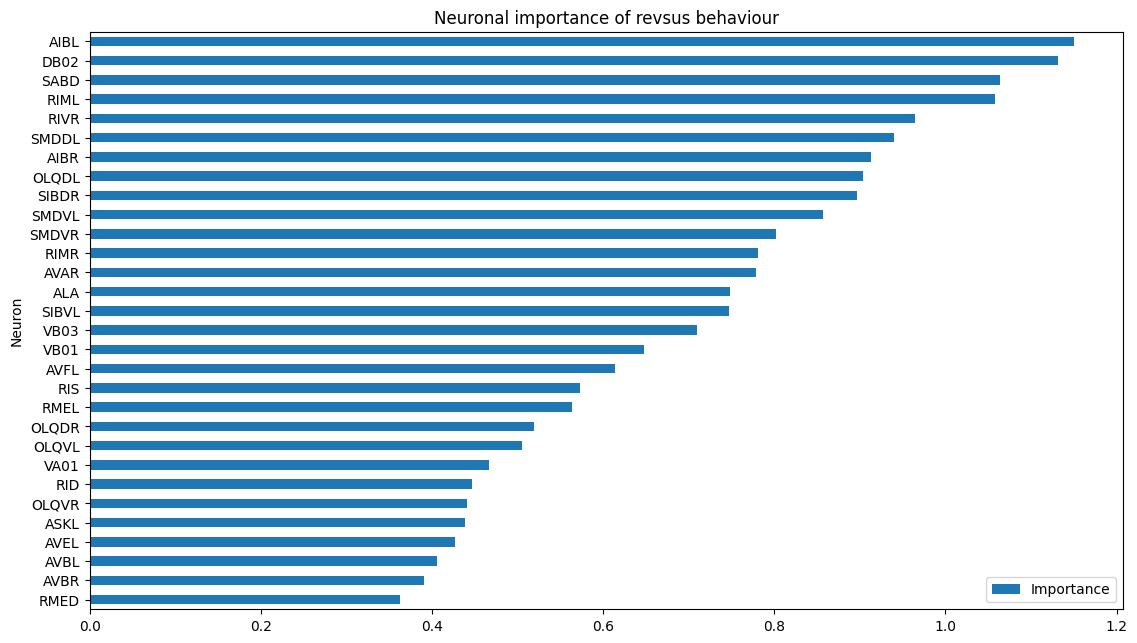

In [18]:
wt_nostim_revsus_behaviour_feature_importance_df = find_relevant_features_from_lr_clf_one_behaviour(
    wt_nostim_lr_clf,
    wt_nostim_neuron_trace_df,
    'revsus'
)

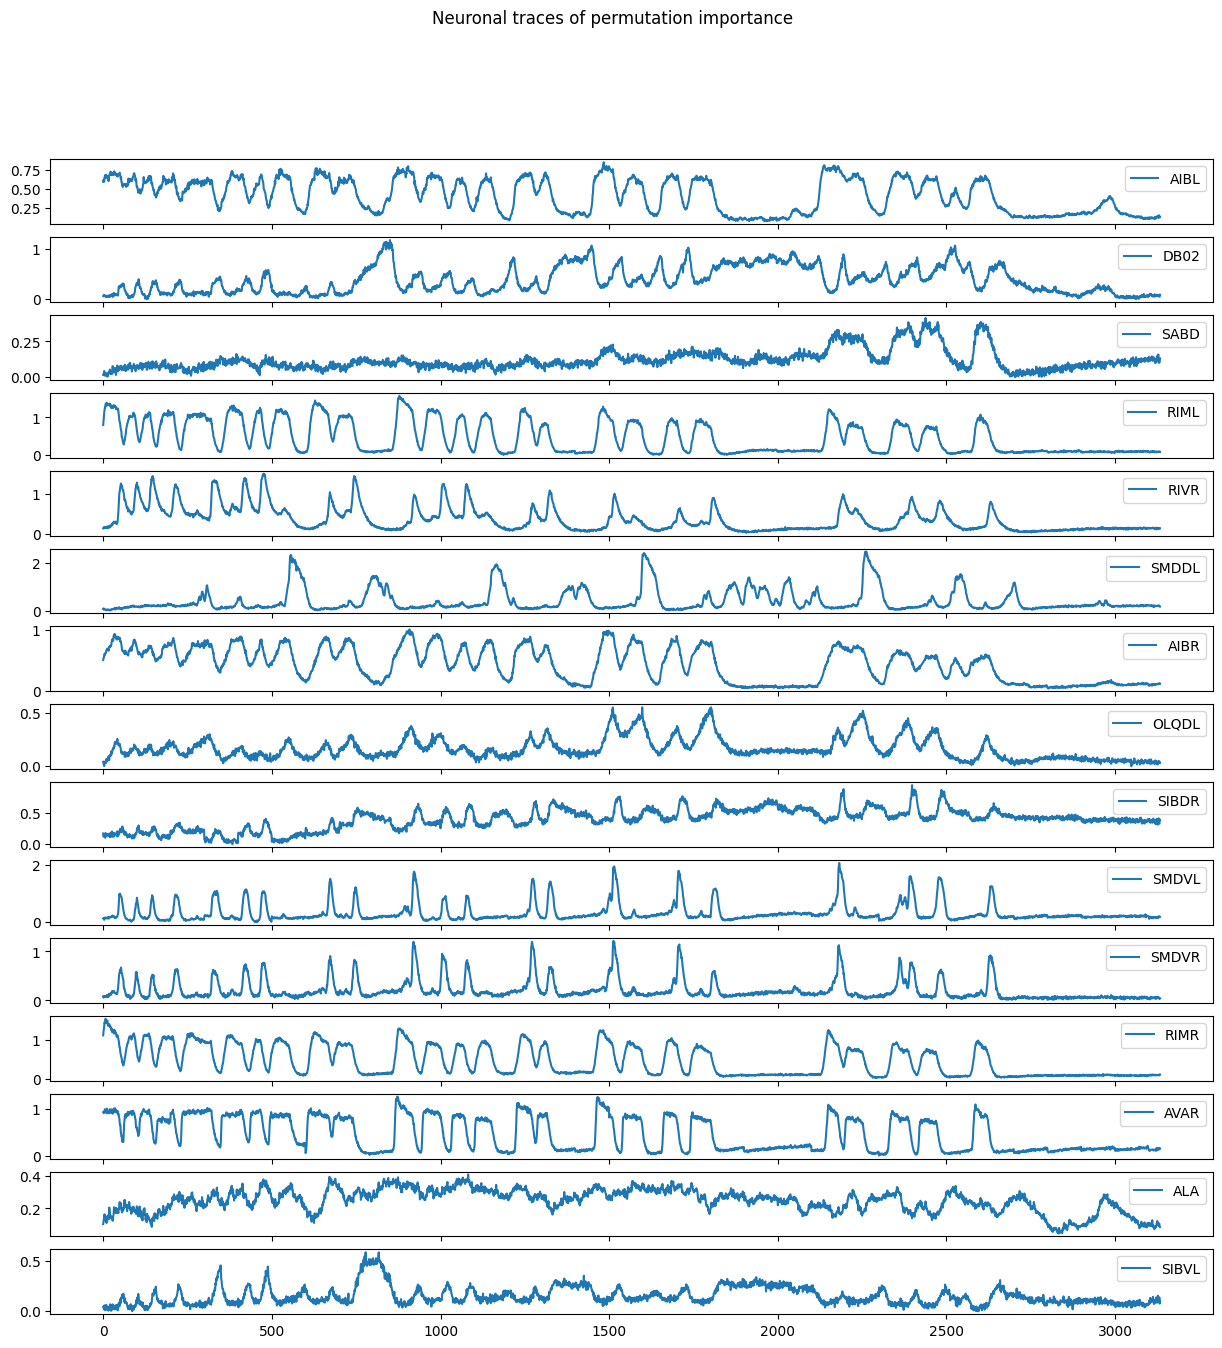

In [19]:
figure_wt_nostim_neuron_trace(
    wt_nostim_neuron_trace_df,
    wt_nostim_revsus_behaviour_feature_importance_df
)

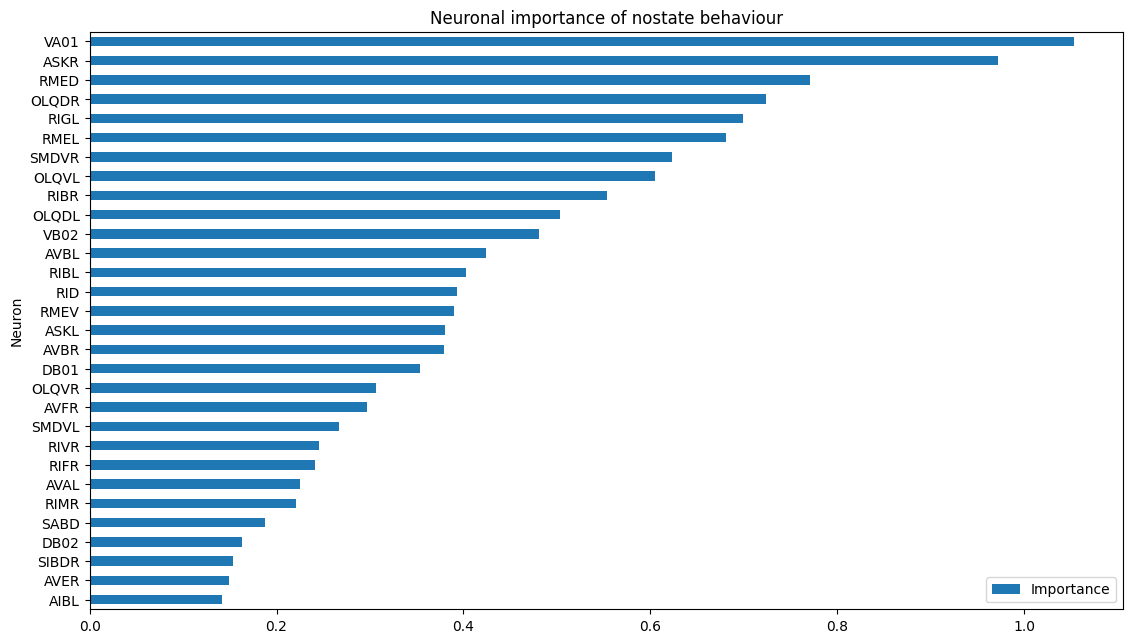

In [20]:
wt_nostim_nostate_behaviour_feature_importance_df = find_relevant_features_from_lr_clf_one_behaviour(
    wt_nostim_lr_clf,
    wt_nostim_neuron_trace_df,
    'nostate'
)

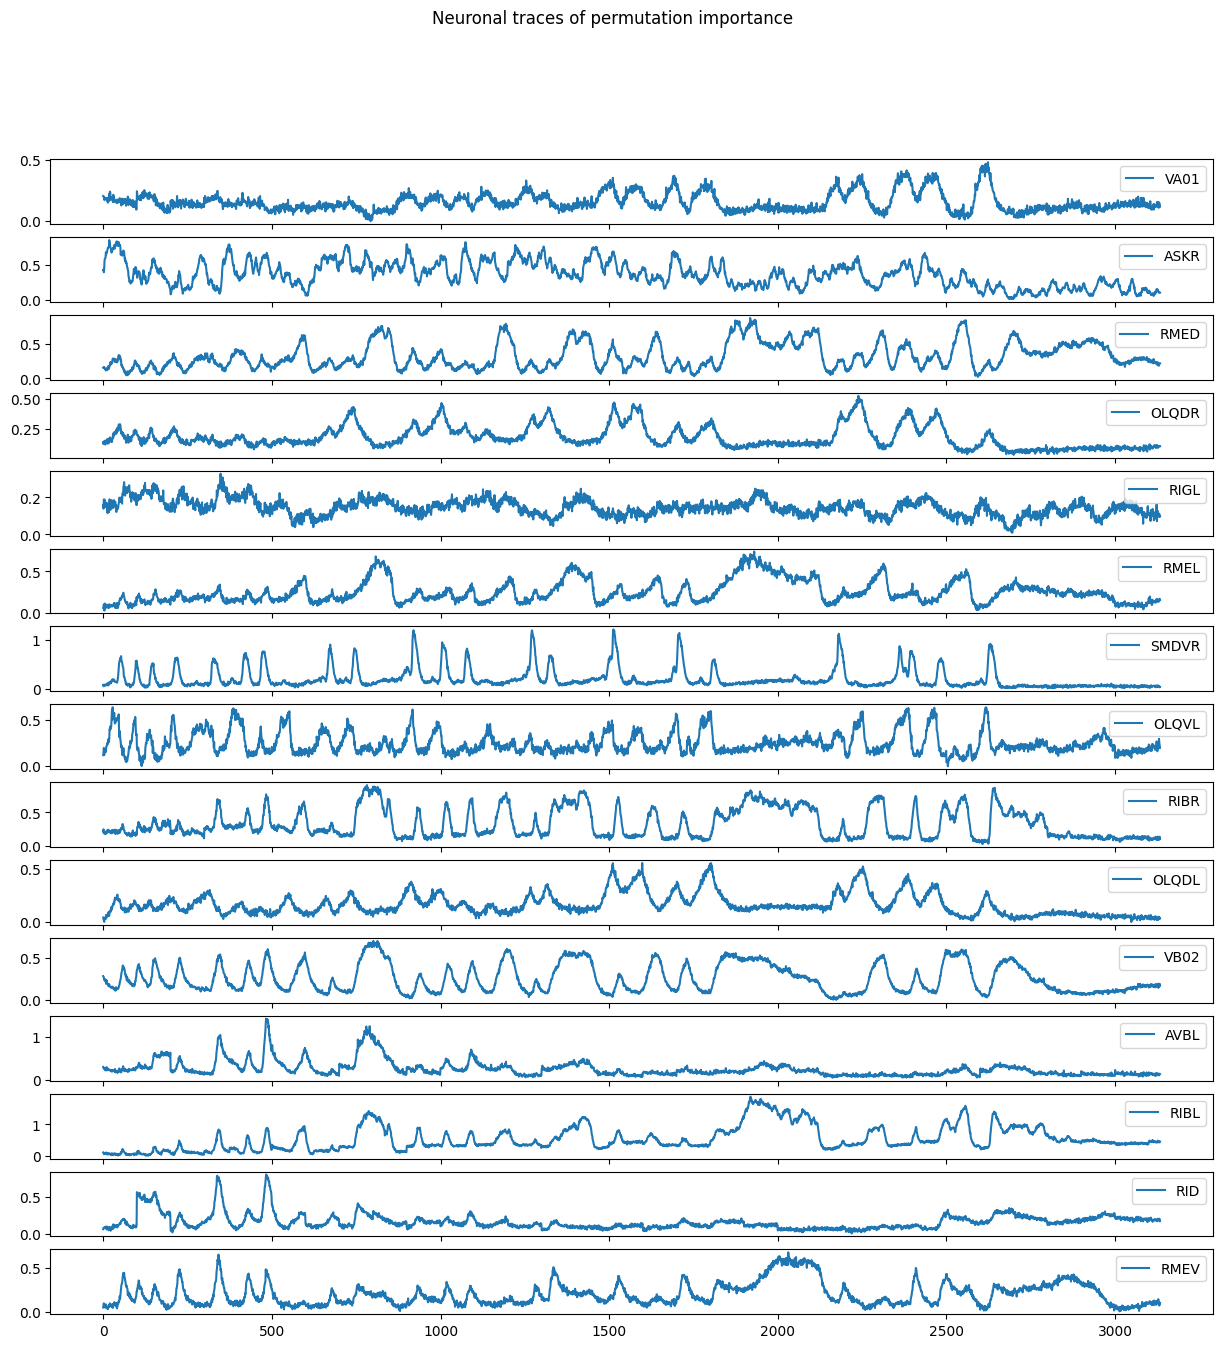

In [21]:
figure_wt_nostim_neuron_trace(
    wt_nostim_neuron_trace_df,
    wt_nostim_nostate_behaviour_feature_importance_df
)

In [22]:
WT_Stim_path = local_path + 'WT_Stim.mat'
wt_stim_dict = mat73.loadmat(WT_Stim_path)
wt_stim = wt_stim_dict.get('WT_Stim')
print(f"WT_Stim dict keys: {wt_stim.keys()}")

WT_Stim dict keys: dict_keys(['IDs', 'States', 'dataset', 'fps', 'stimulus', 'timeVectorSeconds', 'traces', 'tracesDif', 'traces_raw'])


In [23]:
def process_wt_stim():
    index = 0
    neuron_ids = []
    identified_neuron_ids = []
    states = []
    neuron_trace_data = []

    behaviour_type_dict = {
        1: "fwd",
        2: "rev",
        3: "revsus",
        4: "turn"
    }

    for x, y in wt_stim.items():
        if x == 'IDs':
            max = 0
            for idx, v in enumerate(y):
                if len(v) > max:
                    max = len(v)
                    index = idx
                    neuron_ids = v
            for idx, v in enumerate(neuron_ids):
                if v is None:
                    neuron_ids[idx] = str(idx + 1)
                else:
                    neuron_ids[idx] = '/'.join(v)
                    identified_neuron_ids.append(neuron_ids[idx])
            print(f"Using C. elegans GCaMP data with the highest number of neurons monitored, "
                  f"detected neurons len: {len(neuron_ids)}, identified neurons len: {len(identified_neuron_ids)}, IDs: {identified_neuron_ids}")
        if x == 'States':
            states = y[index].astype(np.int64)
            states = [behaviour_type_dict.get(k) for k in states]
        if x == 'stimulus':
            stimulus = y[index]
            print(f"stimulus: {stimulus}")
        if x == 'traces':
            neuron_trace_data = y[index]

    return states, neuron_trace_data, neuron_ids, identified_neuron_ids


In [24]:
wt_stim_behaviours, wt_stim_neuron_trace_data, wt_stim_neuron_ids, wt_stim_identified_neuron_ids = process_wt_stim()

wt_stim_behaviour_df = pd.DataFrame({'behaviour': wt_stim_behaviours})
print(f"\n wt_stim behaviour data:")
print(wt_stim_behaviour_df.info())
print(wt_stim_behaviour_df)

wt_stim_neuron_trace_df = pd.DataFrame(wt_stim_neuron_trace_data, columns=wt_stim_neuron_ids)
wt_stim_neuron_trace_df = wt_stim_neuron_trace_df[wt_stim_identified_neuron_ids]
print(f"wt_stim neuron trace data:")
print(wt_stim_neuron_trace_df.info())
print(wt_stim_neuron_trace_df)

Using C. elegans GCaMP data with the highest number of neurons monitored, detected neurons len: 151, identified neurons len: 44, IDs: ['URYDL', 'URYDR', 'OLQDL', 'OLQVL/URYVL', 'OLQDR', 'RMEL', 'BAGL', 'RMED', 'BAGR', 'RMER', 'RID', 'AVAL', 'SMDVL', 'AVAR', 'RMDL', 'SMDVR', 'RMDR', 'URXL', 'ALA', 'AVER', 'URXR', 'ASKR', 'AVEL', 'AIBR', 'AVBL', 'AIBL', 'RIBR', 'SIBVR', 'RIBL', 'SMBDL', 'RIMR', 'RIVL', 'SMBDR', 'RIML', 'AQR', 'RIS', 'VB02', 'SABVR', 'AVFR', 'RIGR', 'RIFL', 'VB01', 'RIGL', 'DB01']
stimulus: {'conc': array([ 4., 21.]), 'concunits': '%', 'identity': 'O2', 'initialstate': array(2.), 'switchtimes': array([360., 390., 420., 450., 480., 510., 540., 570., 600., 630., 660.,
       690.]), 'type': 'binarysteps'}

 wt_stim behaviour data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2017 entries, 0 to 2016
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   behaviour  2017 non-null   object
dtypes: object(1)
memory

In [25]:
wt_stim_neuron_trace_train, wt_stim_neuron_trace_test, wt_stim_behaviour_train, wt_stim_behaviour_test = train_test_split(
    wt_stim_neuron_trace_df,
    wt_stim_behaviour_df,
    test_size=0.3,
    random_state=42
)

wt_stim_neuron_trace_train_prepared = pre_process_data(wt_stim_neuron_trace_train)
print(f"wt_stim neuron trace train prepared:")
print(wt_stim_neuron_trace_train_prepared.shape)
print(wt_stim_neuron_trace_train_prepared)

wt_stim_neuron_trace_test_prepared = pre_process_data(wt_stim_neuron_trace_test)
print(f"wt_stim neuron trace test prepared:")
print(wt_stim_neuron_trace_test_prepared.shape)
print(wt_stim_neuron_trace_test_prepared)

wt_stim neuron trace train prepared:
(1411, 44)
[[-0.39534776 -1.11169938 -0.41201547 ... -0.77792939 -1.04870593
  -0.78995686]
 [ 1.59987558  2.23346432 -0.31223177 ... -0.27413312  0.02685245
  -0.34153007]
 [-0.04882759  0.65475031 -0.86918311 ... -0.17973009 -1.02683037
  -0.73811505]
 ...
 [-0.88419189 -0.78823697  0.47224558 ... -0.55375686 -0.63720566
  -0.57330303]
 [-0.23458119 -0.5341466  -1.29724047 ...  0.32006284  0.58291121
   1.74267578]
 [ 0.64431051  0.21158311 -0.65005377 ...  1.47696296  0.65531033
  -0.06405518]]
wt_stim neuron trace test prepared:
(606, 44)
[[-0.66807172 -0.98017282 -0.91337478 ...  0.34844842  0.43429287
   1.62381223]
 [-0.80033462 -1.36873409 -0.76532958 ... -0.79231719 -0.94018941
  -0.6389397 ]
 [-0.3977755  -0.17860376  0.67323623 ... -0.72547393 -1.14798729
  -0.80869773]
 ...
 [-0.87035974 -0.89150247 -0.39118148 ... -0.40488761 -0.68055495
  -0.70475642]
 [-0.19138619 -0.48371388  0.62992025 ... -0.75185674 -0.39361747
  -0.73580655]
 [-0

Fitting 10 folds for each of 5 candidates, totalling 50 fits
LogisticRegression classifier optimal parameters: {'C': 1, 'penalty': 'l2', 'solver': 'newton-cg'}
Logistic Regression Classifier Accuracy:  96.4%

Logistic Regression Classifier Confusion Matrix:


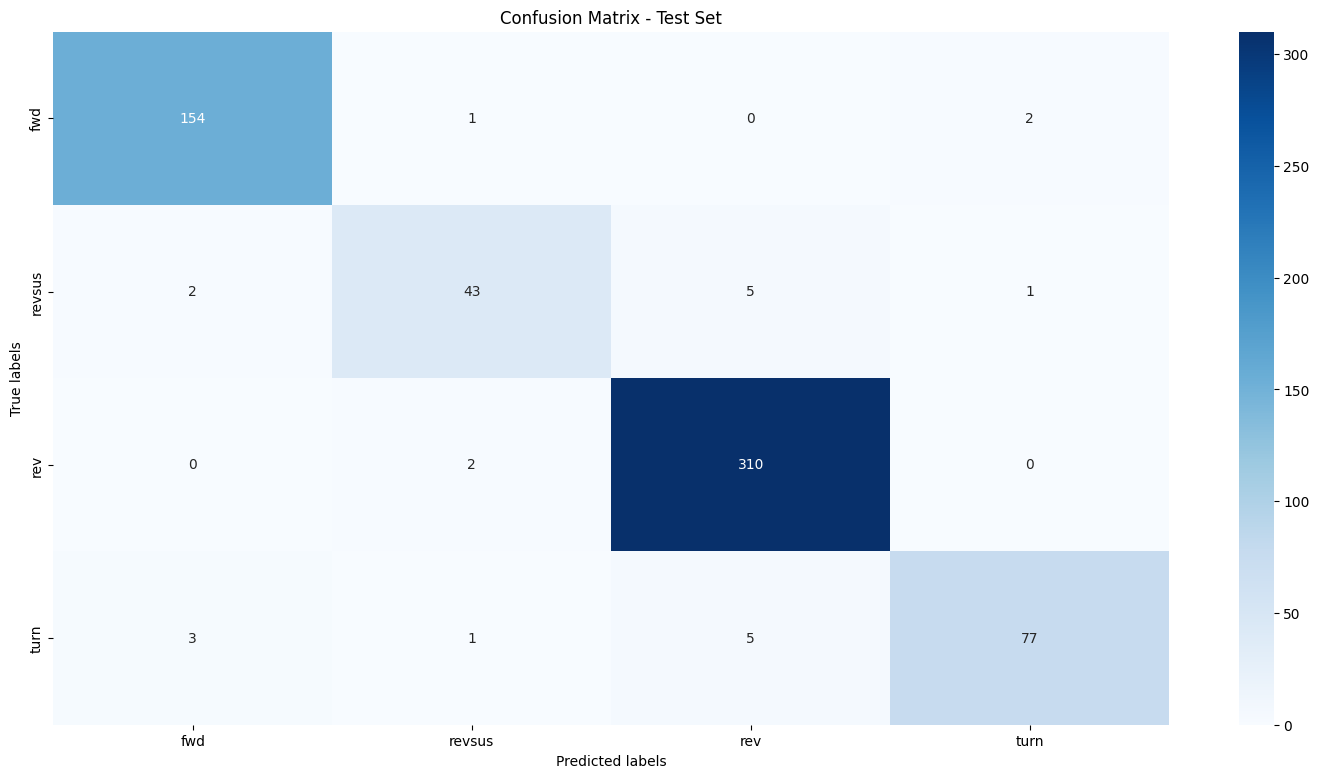


 Logistic Regression Classifier Classification Report:
              precision    recall  f1-score   support

         fwd       0.97      0.98      0.97       157
         rev       0.91      0.84      0.88        51
      revsus       0.97      0.99      0.98       312
        turn       0.96      0.90      0.93        86

    accuracy                           0.96       606
   macro avg       0.95      0.93      0.94       606
weighted avg       0.96      0.96      0.96       606



In [26]:
wt_stim_lr_clf = train_and_evaluate_logistic_regression_classifiers(
    wt_stim_neuron_trace_train_prepared,
    wt_stim_behaviour_train,
    wt_stim_neuron_trace_test_prepared,
    wt_stim_behaviour_test
)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Random Forest classifier optimal parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Random Forest Classifier Accuracy:  96.2%

Random Forest Classifier Confusion Matrix:


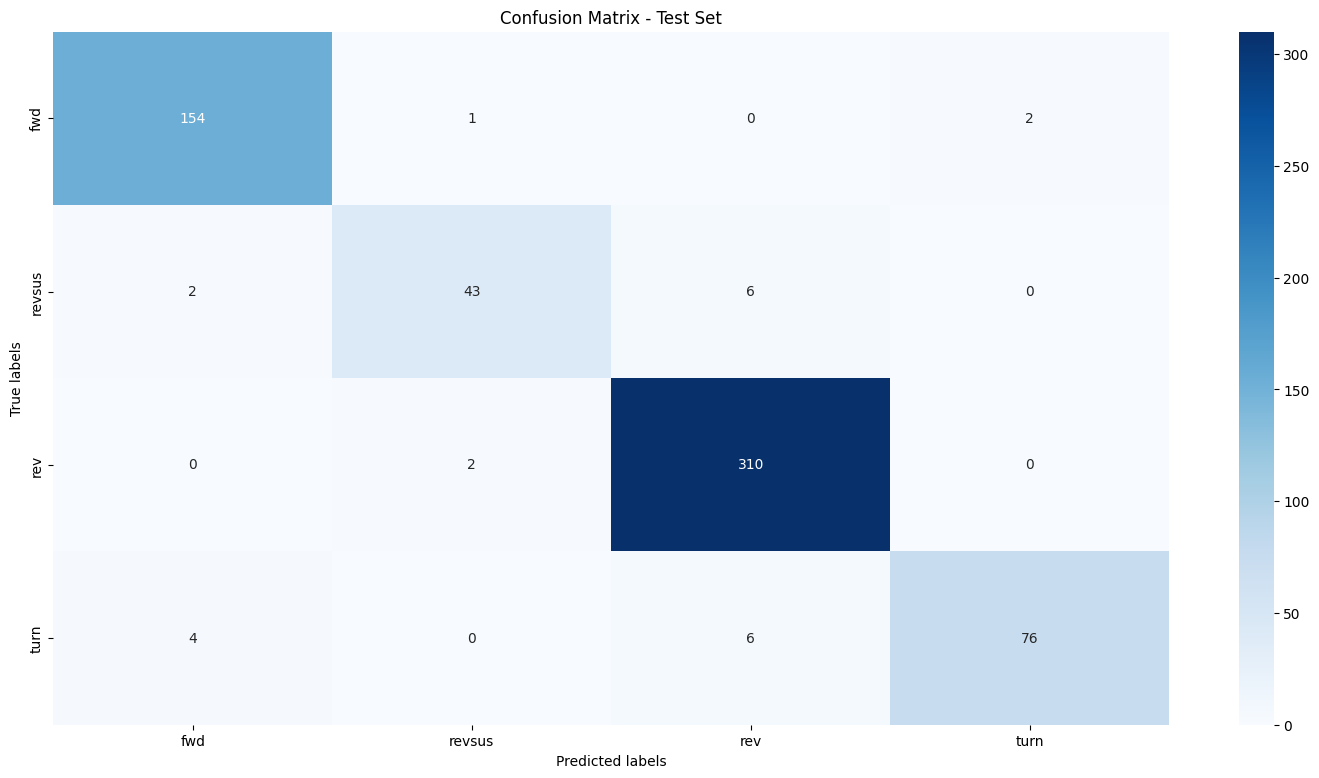


 Random Forest Classifier Classification Report:
              precision    recall  f1-score   support

         fwd       0.96      0.98      0.97       157
         rev       0.93      0.84      0.89        51
      revsus       0.96      0.99      0.98       312
        turn       0.97      0.88      0.93        86

    accuracy                           0.96       606
   macro avg       0.96      0.93      0.94       606
weighted avg       0.96      0.96      0.96       606



In [27]:
wt_stim_rf_clf = train_and_evaluate_random_forest_classifiers(
    wt_stim_neuron_trace_train_prepared,
    wt_stim_behaviour_train,
    wt_stim_neuron_trace_test_prepared,
    wt_stim_behaviour_test
)

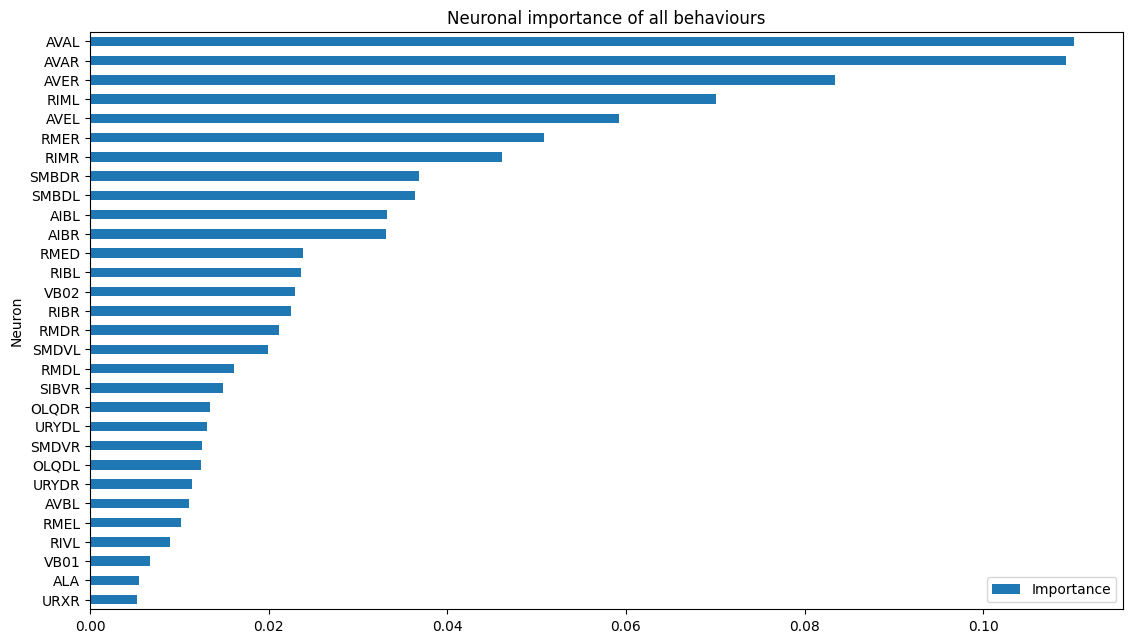

In [28]:
wt_stim_behaviours_feature_importance_df = find_relevant_features_from_rf_clf_all_behaviours(
    wt_stim_rf_clf,
    wt_stim_neuron_trace_df
)

In [29]:
def figure_wt_stim_neuron_trace(df, feature_importance_df):
    neurons = feature_importance_df['Neuron'].head(15).tolist()
    neuron_dict = {}
    for k in neurons:
        neuron_dict[k] = df[k].tolist()[:1000]
    filtered_df = pd.DataFrame(neuron_dict)

    col = len(filtered_df.columns)

    fig, axes = plt.subplots(nrows=col, ncols=1, sharex=True, figsize=(15, 15))
    fig.suptitle('Neuronal traces of permutation importance')

    for c, ax in zip(filtered_df, axes):
        filtered_df[c].plot(ax=ax, label=f'{c}')
        ax.set_xticks(np.arange(0, 1000, step=30))
        ax.legend(loc='upper right')

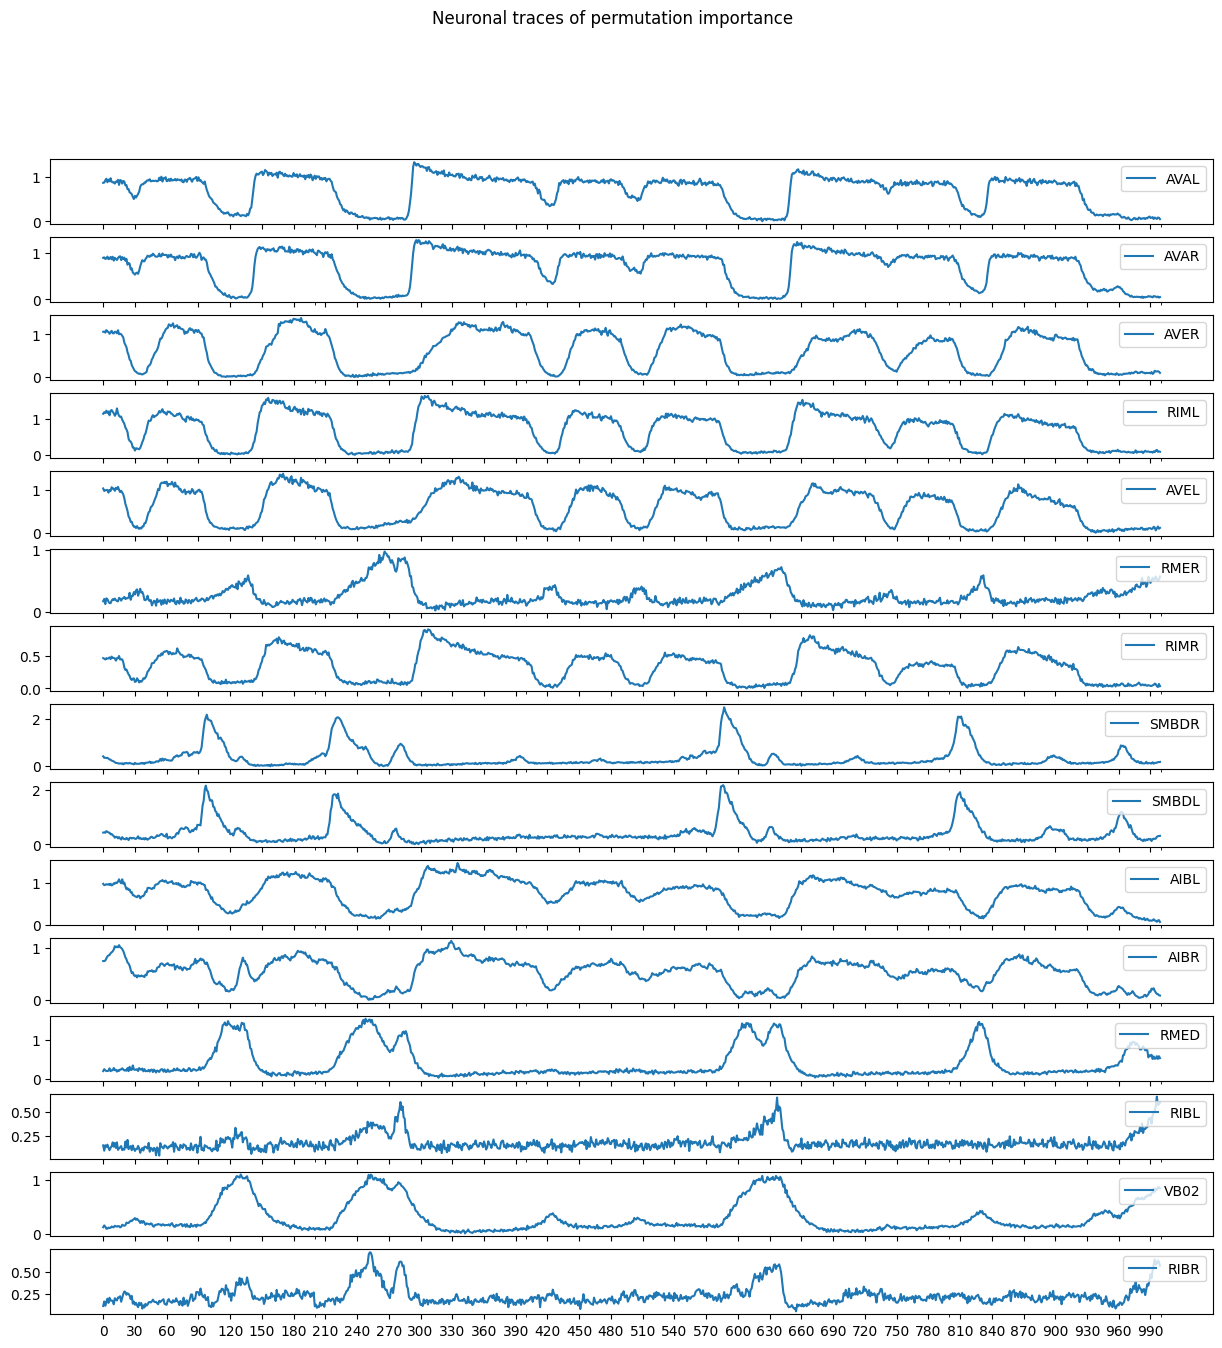

In [30]:
figure_wt_stim_neuron_trace(
    wt_stim_neuron_trace_df,
    wt_stim_behaviours_feature_importance_df
)

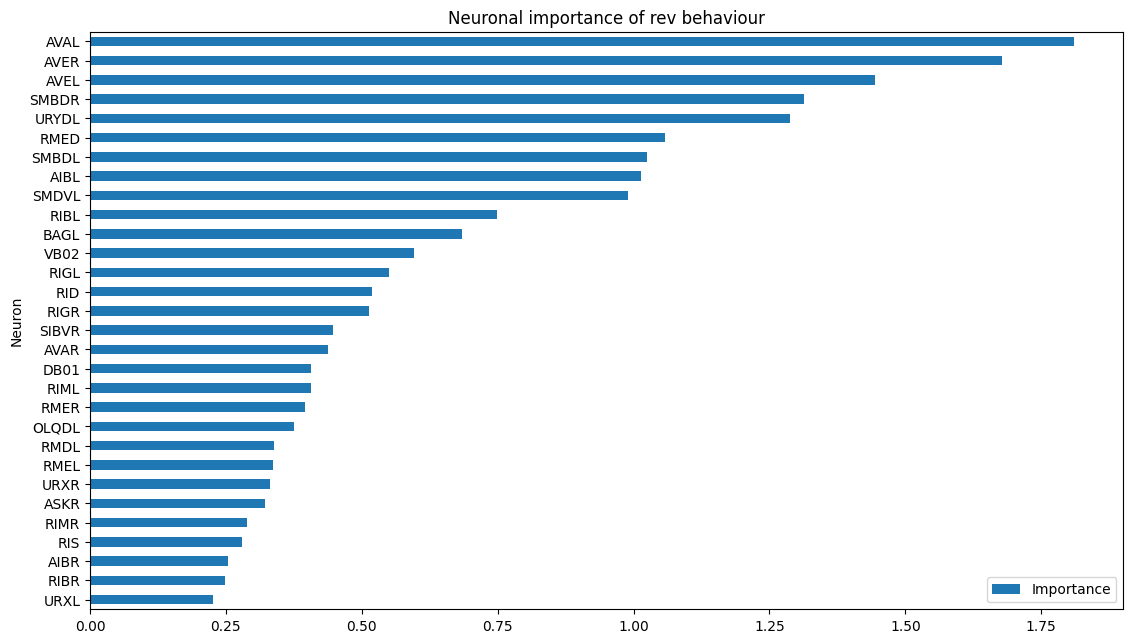

In [31]:
wt_stim_one_behaviour_feature_importance_df = find_relevant_features_from_lr_clf_one_behaviour(
    wt_stim_lr_clf,
    wt_stim_neuron_trace_df,
    'rev'
)

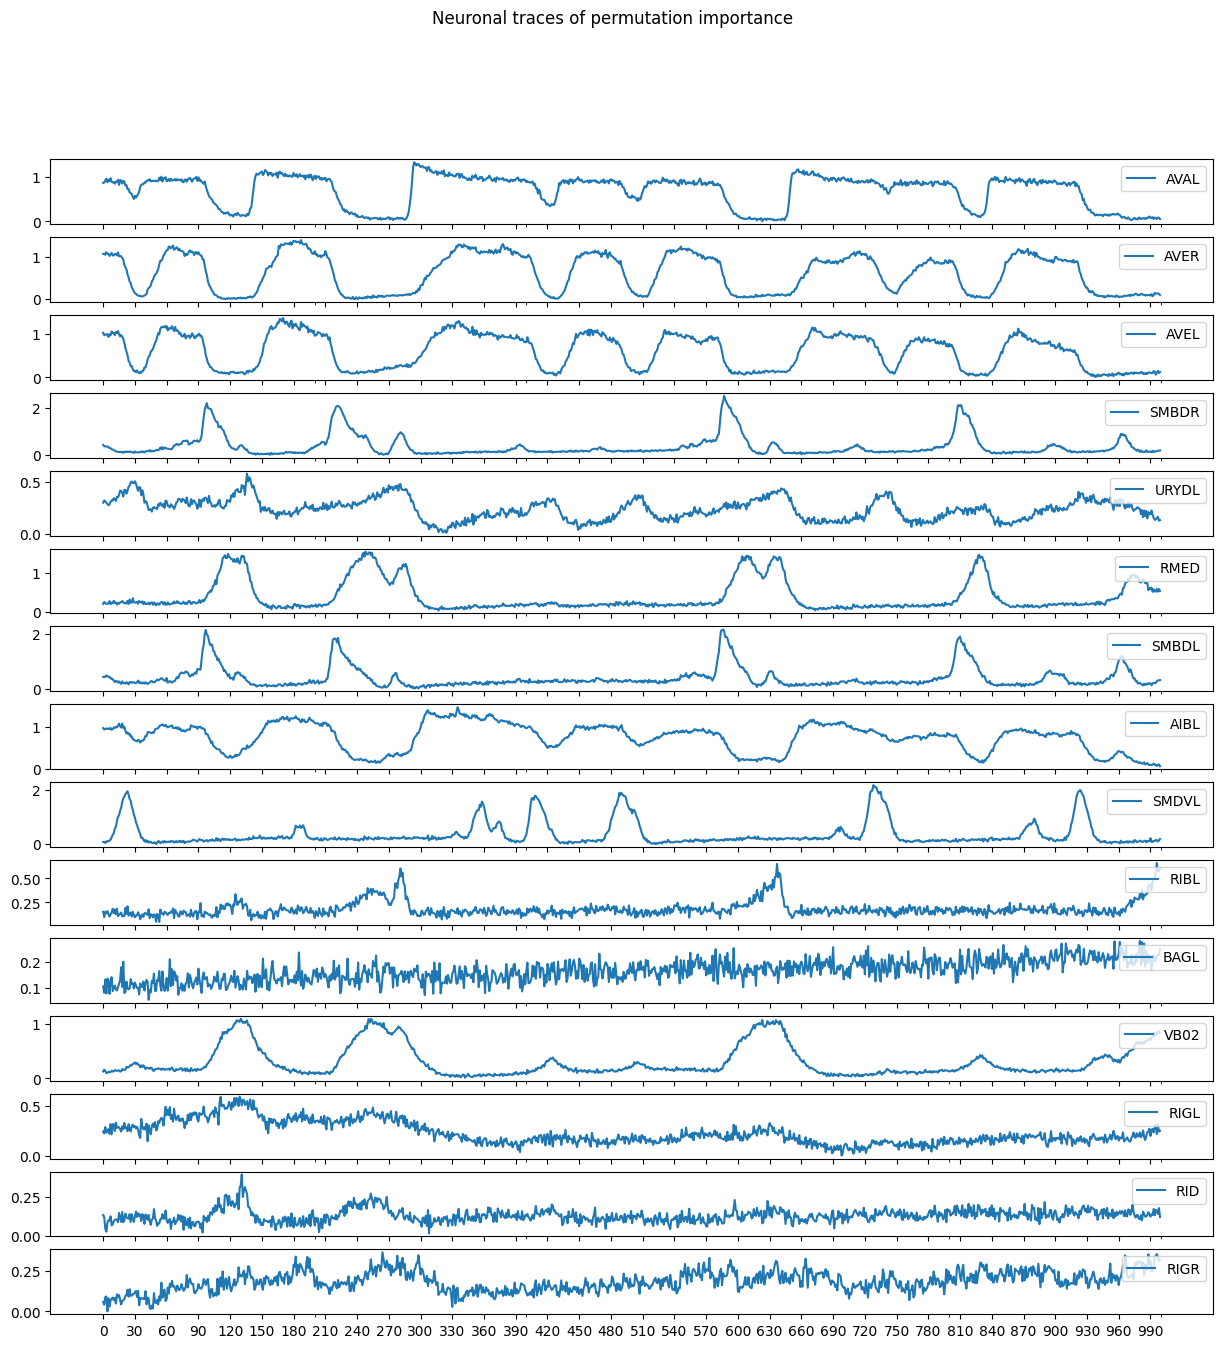

In [32]:
figure_wt_stim_neuron_trace(
    wt_stim_neuron_trace_df,
    wt_stim_one_behaviour_feature_importance_df
)

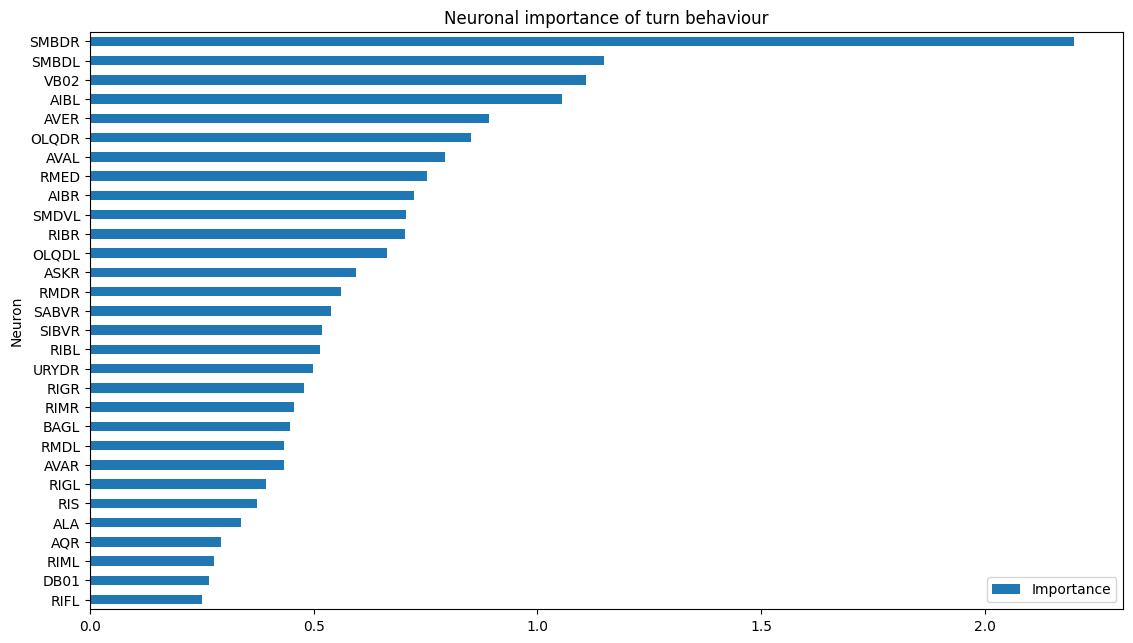

In [33]:
wt_stim_one_behaviour_feature_importance_df = find_relevant_features_from_lr_clf_one_behaviour(
    wt_stim_lr_clf,
    wt_stim_neuron_trace_df,
    'turn'
)

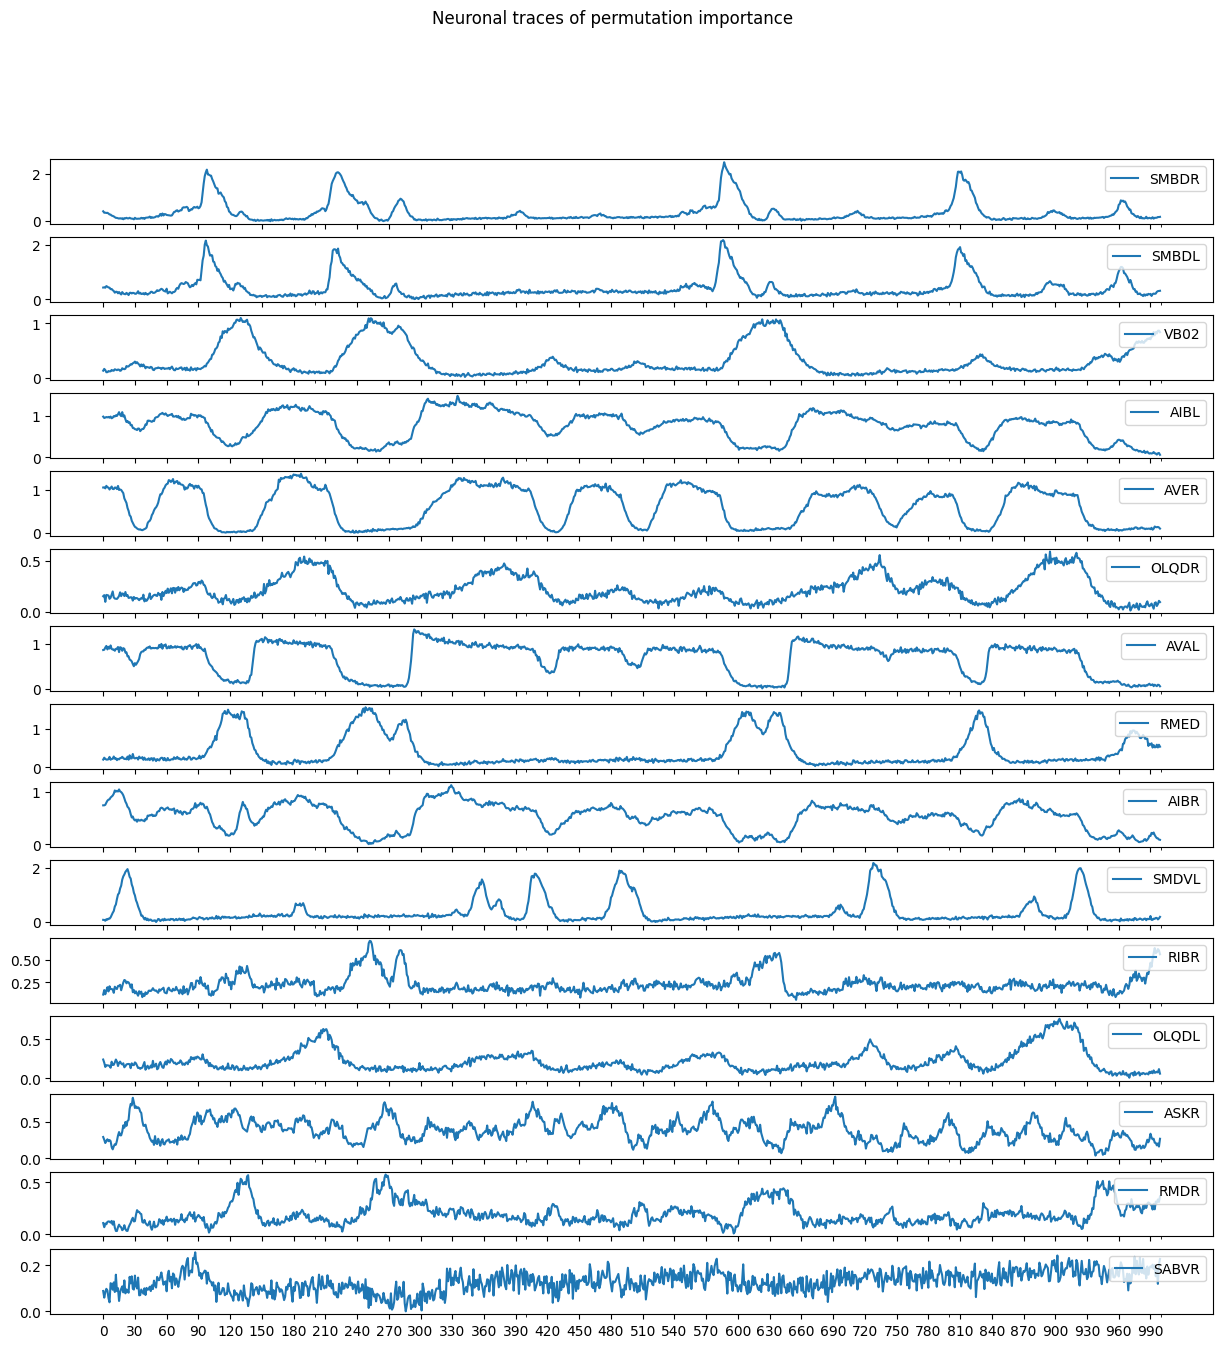

In [34]:
figure_wt_stim_neuron_trace(
    wt_stim_neuron_trace_df,
    wt_stim_one_behaviour_feature_importance_df
)

In [35]:
wt_nostim_neuron_trace_prepared = pre_process_data(wt_nostim_neuron_trace_df)
wt_stim_neuron_trace_prepared = pre_process_data(wt_stim_neuron_trace_df)

In [36]:
def cross_val(best_clf, data_features_prepared, data_targets):
    # K-Fold
    k_folds = KFold(n_splits=10)
    scores = cross_val_score(best_clf, data_features_prepared, data_targets.values.ravel(), cv=k_folds)
    return scores.mean()

In [37]:
wt_nostim_lr_clf_cv = cross_val(wt_nostim_lr_clf, wt_nostim_neuron_trace_prepared, wt_nostim_behaviour_df)
wt_nostim_rf_clf_cv = cross_val(wt_nostim_rf_clf, wt_nostim_neuron_trace_prepared, wt_nostim_behaviour_df)
wt_stim_lr_clf_cv = cross_val(wt_stim_lr_clf, wt_stim_neuron_trace_prepared, wt_stim_behaviour_df)
wt_stim_rf_clf_cv = cross_val(wt_stim_rf_clf, wt_stim_neuron_trace_prepared, wt_stim_behaviour_df)
print(f"wt_nostim logistic regression cv avg score: {wt_nostim_lr_clf_cv}")
print(f"wt_nostim random forest classifier cv avg score: {wt_nostim_rf_clf_cv}")
print(f"wt_stim logistic regression classifier cv avg score: {wt_stim_lr_clf_cv}")
print(f"wt_stim random forest classifier cv avg score: {wt_stim_rf_clf_cv}")

wt_nostim logistic regression cv avg score: 0.6945015363952708
wt_nostim random forest classifier cv avg score: 0.8369467450804826
wt_stim logistic regression classifier cv avg score: 0.8904536722328948
wt_stim random forest classifier cv avg score: 0.9156987340525097
